In [22]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import random
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
import pickle
pd.set_option('display.max_columns', 100)  # or 1000
pd.set_option('display.max_rows', 100)  # or 1000
import time
from numpy import concatenate
Scaler = MinMaxScaler()

In [49]:
## Load training dataset
# Make sure you are in the main folder('..\Algal-bloom-prediction-machine-learning')
cd = os.getcwd()
print(cd)
while cd.split('\\')[-1]!='Algal-bloom-prediction-machine-learning':
    os.chdir('..')
    cd=os.getcwd()
    
os.chdir('Trainning data')
print('Load training data (containing nutrient observations)')
lakename = input('Lake name in short: ')
winter = input('Winter data or not? (Y/N)')
if winter =='Y':
    all_df = pd.read_csv(lakename+'_Observation_df.csv',sep = '\t',parse_dates = ['Date'])
else:
    all_df = pd.read_csv(lakename+'_Observation_df_nowinter.csv',sep = '\t',parse_dates = ['Date'])

C:\Users\shuli278\Documents\D\PDF_Uppsala\7-Python code of ML algorithm\GitHub\Algal-bloom-prediction-machine-learning\Algal-bloom-prediction-machine-learning\Scenario2\GBR
Load training data (containing nutrient observations)
Lake name in short: Ekoln
Winter data or not? (Y/N)N


In [24]:
## Specify the training year
year = all_df['Date'].apply(lambda d:d.year).unique()
print('Dataset contains years:{},in total {} years'.format(year,len(year)))#[2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016] 
num_trainingyr = int(input('Number of years for training:'))
training_yr = []
for i in range(num_trainingyr):
    yr = int(input('Training year:'))
    training_yr.append(yr)

Dataset contains years:[1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000
 2001 2002 2003 2004 2005 2006 2007 2009 2010 2011 2012 2013 2014 2015
 2016 2017 2018 2019],in total 32 years
Number of years for training:26
Training year:1987
Training year:1988
Training year:1989
Training year:1990
Training year:1991
Training year:1992
Training year:1993
Training year:1994
Training year:1995
Training year:1996
Training year:1997
Training year:1998
Training year:1999
Training year:2000
Training year:2001
Training year:2002
Training year:2003
Training year:2004
Training year:2005
Training year:2006
Training year:2007
Training year:2009
Training year:2010
Training year:2011
Training year:2012
Training year:2013


# GBR model

In [25]:
# Load testing dataset(Daily data)
def read_daily_test_df(test_time,features,file): # test_time = pd.Timestamp(yyyy,mm,dd)
    Lake_HydMet = pd.read_csv(file,header = 0,sep = '\t',parse_dates = ['Date'])
    Lake_HydMet = Lake_HydMet[features]
    Lake_HydMet = Lake_HydMet[(Lake_HydMet['Date']>=test_time[0])&(Lake_HydMet['Date']<=test_time[1])].dropna()
    return Lake_HydMet

In [46]:
def training_cv(df,features,nutrient,year,loss_func):
    df['YY'] = df['Date'].apply(lambda d:d.year)
    features.append(nutrient)
    df = df[df['YY'].isin(year)][features].dropna()
    X_train = df.iloc[:,:-1]
    y_train = df.iloc[:,-1].values

    GBR = GradientBoostingRegressor(random_state=101)
    #loss=['squared_error', 'absolute_error', 'huber', 'quantile']
    n_estimators = [int(x) for x in np.arange(40,140,20)]
    max_depth=[int(x) for x in np.arange(5,10,1)]
    learning_rate = [x for x in [0.01,0.1,1]]
    subsample = [x for x in [0.7,0.8,0.9,1]]
    param_grid = {'n_estimators': n_estimators,
                  'max_depth': max_depth,
                  'learning_rate':learning_rate,
                  'subsample':subsample}
    GBR_rs = RandomizedSearchCV(estimator = GBR,param_distributions = param_grid,n_iter = 30,cv = 5,verbose = 0)
    GBR_rs.fit(X_train,y_train)
    #print(GBR_rs.best_params_)
    GBR.set_params(**GBR_rs.best_params_,random_state=101,loss=loss_func).fit(X_train,y_train)
    rmse = np.sqrt(-cross_val_score(GBR, X_train, y_train, cv=5,scoring = 'neg_mean_squared_error'))
    r2 = cross_val_score(GBR, X_train, y_train, cv=5,scoring = 'r2')
    print('Training dataset evaluation:')
    print("RMSE %.2f (+/- %.2f)" % (rmse.mean(), rmse.std()))
    print("R2 %.2f (+/- %0.2f)" % (r2.mean(), r2.std()))
    pickle.dump(GBR, open("GBR."+nutrient.split('(')[0]+".dat", "wb"))
    features.pop()

In [27]:
def predict(Lake_Nut,df,features,nutrient,test_time,ylim):
    #load the target GBR model
    GBR = pickle.load(open("GBR."+nutrient.split('(')[0]+".dat", "rb"))
    #predict yhat using test_X
    Lake_Nut[nutrient] =GBR.predict(Lake_Nut[features])
    nutrient_compare = Lake_Nut[['Date',nutrient]].merge(df[['Date',nutrient]],
                                                          how = 'inner',on = 'Date').dropna()
    nutrient_compare.columns = ['Date','Prediction','True']
    Date = pd.DataFrame(pd.date_range(start = test_time[0],
                                  end = test_time[1]),
                    columns = ['Date'])
    Lake_Nut_gap = Date.merge(Lake_Nut,how = 'left',on = 'Date')
    #nutrient_compare['Prediction_7d'] = Erken_Nut[nutrient]

    RMSE = np.sqrt(mean_squared_error(nutrient_compare['True'],nutrient_compare['Prediction']))
    #plot time-series comparison
    f2,ax2 = plt.subplots(1,2,figsize = (18,6),gridspec_kw={'width_ratios': [2, 1]})
    Lake_Nut_gap.plot(x = 'Date',y =nutrient,c = 'b',ax = ax2[0],label = 'Predicted '+nutrient)
    Lake_Nut[nutrient] = Lake_Nut[nutrient].rolling(7,min_periods = 1).mean() # take the 7-day moving mean
    Lake_Nut_gap[nutrient] = Lake_Nut_gap[nutrient].rolling(7,min_periods = 1).mean()
    Lake_Nut_gap.plot(x = 'Date',y =nutrient,c = 'k',ax = ax2[0],label = 'Predicted 7d-averaged '+nutrient)
    df[['Date',nutrient]].plot(x = 'Date',y =nutrient,style = 'ro',ms = 7,alpha = 0.7,ax = ax2[0],label = 'Observation')
    ax2[0].text(0.2, 0.8, 'RMSE:{}'.format(round(RMSE,2)), 
            horizontalalignment='center',verticalalignment='center', 
            transform=ax2[0].transAxes,fontsize='x-large')
    ax2[0].set_xlim((test_time[0],test_time[1]))
    ax2[0].set_ylim(ylim)
    
    R2 = r2_score(nutrient_compare['True'],nutrient_compare['Prediction'])
    #plot scatter plot
    ax2[1].scatter(nutrient_compare['True'],nutrient_compare['Prediction'],s = 20,c = 'blue')
    ax2[1].plot(nutrient_compare['True'],nutrient_compare['True'],lw  =1.5,color = 'black')    
    ax2[1].set_xlabel('True value')
    ax2[1].set_ylabel('Prediction')
    ax2[1].text(0.5, 0.8, 'R2:{}'.format(round(R2,2)), 
            horizontalalignment='center',verticalalignment='center', 
            transform=ax2[1].transAxes,fontsize='x-large')
    
    return Lake_Nut,f2

In [47]:
print(all_df.info())
n_feature = int(input('Number of features used for training: '))
features = ['Date']
for i in range(n_feature):
    f = input('Feature:')
    features.append(f)
print(features)
test_time = [pd.Timestamp(int(input('test starts in year:')),1,1),pd.Timestamp(int(input('test ends in year:')),1,1)]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297 entries, 0 to 296
Data columns (total 25 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Date             297 non-null    datetime64[ns]
 1   thermD           297 non-null    float64       
 2   MLD              297 non-null    float64       
 3   swr              297 non-null    float64       
 4   U                297 non-null    float64       
 5   AirP             297 non-null    float64       
 6   AirT             297 non-null    float64       
 7   CC               297 non-null    float64       
 8   Prec             297 non-null    float64       
 9   RelHum           297 non-null    float64       
 10  Inflow           297 non-null    float64       
 11  W                297 non-null    float64       
 12  delT             297 non-null    float64       
 13  Ice_d            297 non-null    int64         
 14  day_from_iceoff  297 non-null    float64  

In [50]:
if winter =='Y':
    file = lakename+'_Daily_Observation_df.csv'
else:
    file = lakename+'_Daily_Observation_df_nowinter.csv'
testing_daily_df = read_daily_test_df(test_time,features,file) 

C:\Users\shuli278\Documents\D\PDF_Uppsala\7-Python code of ML algorithm\GitHub\Algal-bloom-prediction-machine-learning\Algal-bloom-prediction-machine-learning\Trainning data
Nutrient: NOX
Training dataset evaluation:
RMSE 236.47 (+/- 49.40)
R2 0.51 (+/- 0.09)


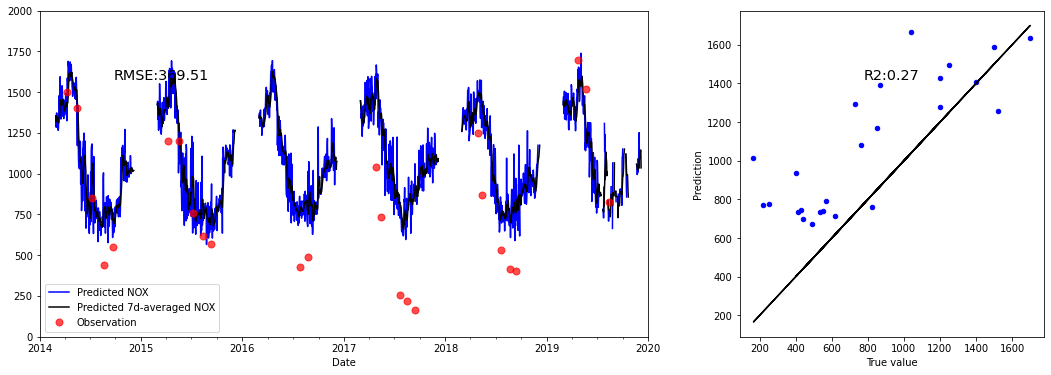

In [51]:
## Predict nutrient 1
cd = os.getcwd()
print(cd)
while cd.split('\\')[-1]!='Algal-bloom-prediction-machine-learning':
    os.chdir('..')
    cd=os.getcwd()
    
os.chdir('Scenario2\\GBR')
nutrient = input('Nutrient: ')
features.pop(0) # remove 'Date' from features
loss_func='huber'
model = training_cv(all_df,features,nutrient,training_yr,loss_func)
ylim = (-1,all_df[nutrient].max())
Lake_Nut,f2 = predict(testing_daily_df,all_df,features,nutrient,test_time,ylim)
f2.savefig(lakename+'_GBR_'+nutrient+'.png',dpi = 500)

Nutrient: O2
['thermD', 'MLD', 'W', 'U', 'CC', 'AirT', 'AirP', 'Prec', 'RelHum', 'swr', 'Inflow', 'delT', 'Ice_d', 'day_from_iceoff']
Delete features? (Y/N)N
Add features? (Y/N)Y
New feature:NOX
['thermD', 'MLD', 'W', 'U', 'CC', 'AirT', 'AirP', 'Prec', 'RelHum', 'swr', 'Inflow', 'delT', 'Ice_d', 'day_from_iceoff', 'NOX']
Add features? (Y/N)N
Training dataset evaluation:
RMSE 0.97 (+/- 0.15)
R2 0.56 (+/- 0.08)


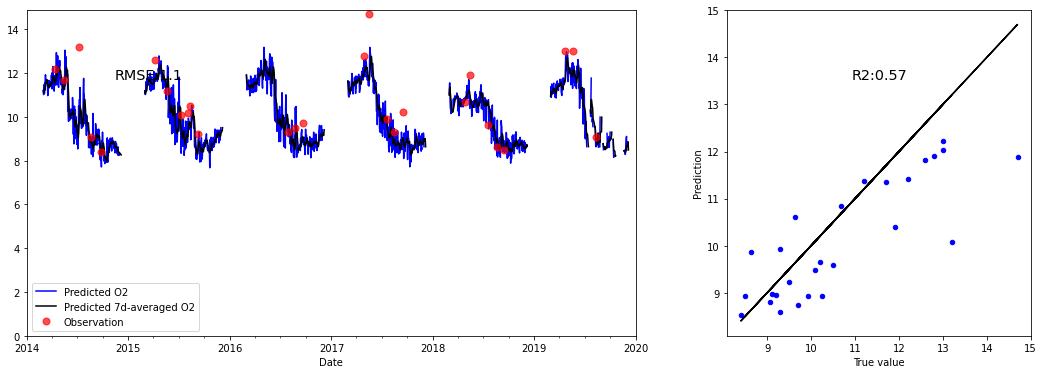

In [52]:
## Predict nutrient 2
nutrient = input('Nutrient: ')
print(features)
delet = input('Delete features? (Y/N)')
while delet=='Y':
    print(features)
    idx = int(input('Location of the feature:'))
    features.pop(idx)
    delet = input('Delete features? (Y/N)')
add = input('Add features? (Y/N)')
while add =='Y':
    f = input('New feature:')
    features.append(f)
    print(features)
    add = input('Add features? (Y/N)')
    
loss_func='huber'
model = training_cv(all_df,features,nutrient,training_yr,loss_func)
ylim = (0,all_df[nutrient].max())
Lake_Nut,f2 = predict(testing_daily_df,all_df,features,nutrient,test_time,ylim)
f2.savefig(lakename+'_GBR_'+nutrient+'.png',dpi = 500)

Nutrient: PO4-P
['thermD', 'MLD', 'W', 'U', 'CC', 'AirT', 'AirP', 'Prec', 'RelHum', 'swr', 'Inflow', 'delT', 'Ice_d', 'day_from_iceoff', 'NOX', 'O2']
Delete features? (Y/N)N
Add features? (Y/N)N
Training dataset evaluation:
RMSE 7.45 (+/- 1.35)
R2 0.64 (+/- 0.09)


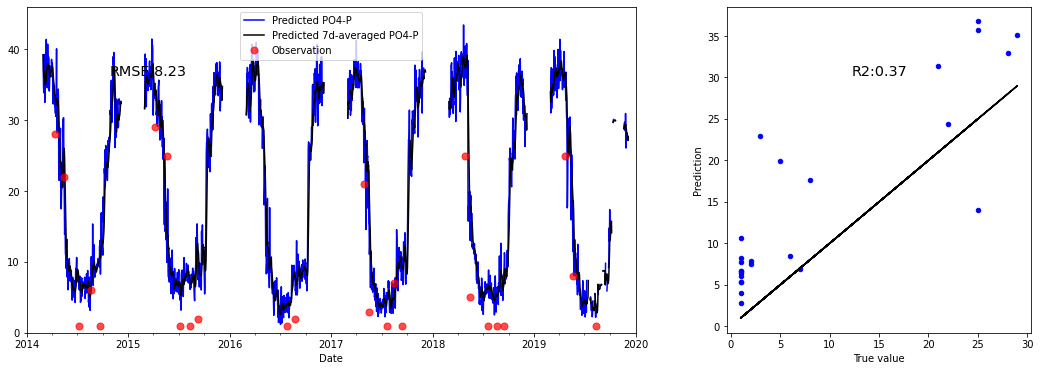

In [57]:
## Predict nutrient 3
nutrient = input('Nutrient: ')
print(features)
delet = input('Delete features? (Y/N)')
while delet=='Y':
    print(features)
    idx = int(input('Location of the feature:'))
    features.pop(idx)
    delet = input('Delete features? (Y/N)')
add = input('Add features? (Y/N)')
while add =='Y':
    f = input('New feature:')
    features.append(f)
    print(features)
    add = input('Add features? (Y/N)')    

loss_func='squared_error'
model = training_cv(all_df,features,nutrient,training_yr,loss_func)
ylim = (0,all_df[nutrient].max())
Lake_Nut,f2 = predict(testing_daily_df,all_df,features,nutrient,test_time,ylim)
f2.savefig(lakename+'_GBR_'+nutrient+'.png',dpi = 500)

Nutrient: Tot-P
['thermD', 'MLD', 'W', 'U', 'CC', 'AirT', 'AirP', 'Prec', 'RelHum', 'swr', 'Inflow', 'delT', 'Ice_d', 'day_from_iceoff', 'NOX', 'O2', 'PO4-P', 'Tot-P']
Delete features? (Y/N)Y
['thermD', 'MLD', 'W', 'U', 'CC', 'AirT', 'AirP', 'Prec', 'RelHum', 'swr', 'Inflow', 'delT', 'Ice_d', 'day_from_iceoff', 'NOX', 'O2', 'PO4-P', 'Tot-P']
Location of the feature:-1
Delete features? (Y/N)N
Add features? (Y/N)N
Training dataset evaluation:
RMSE 12.10 (+/- 2.44)
R2 0.31 (+/- 0.17)


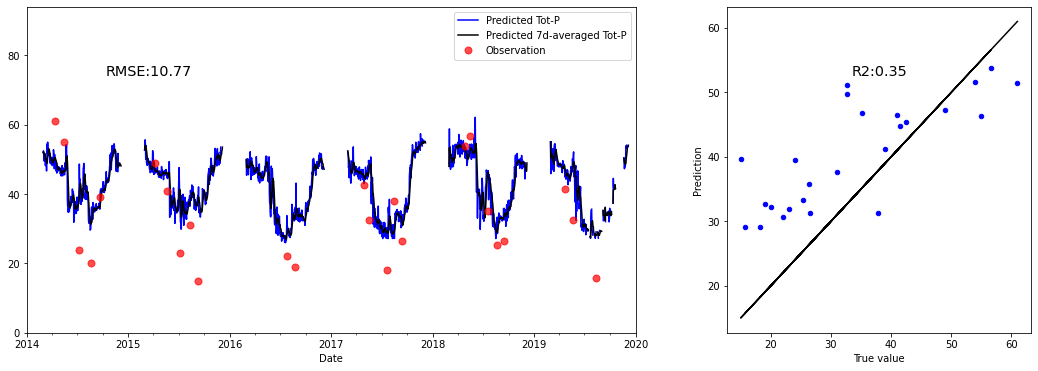

In [63]:
## Predict nutrient 4
nutrient = input('Nutrient: ')
print(features)
delet = input('Delete features? (Y/N)')
while delet=='Y':
    print(features)
    idx = int(input('Location of the feature:'))
    features.pop(idx)
    delet = input('Delete features? (Y/N)')
add = input('Add features? (Y/N)')
while add =='Y':
    f = input('New feature:')
    features.append(f)
    print(features)
    add = input('Add features? (Y/N)')    

loss_func='squared_error'
model = training_cv(all_df,features,nutrient,training_yr,loss_func)
ylim = (0,all_df[nutrient].max())
Lake_Nut,f2 = predict(testing_daily_df,all_df,features,nutrient,test_time,ylim)
f2.savefig(lakename+'_GBR_'+nutrient+'.png',dpi = 500)

Nutrient: NH4-N
['thermD', 'MLD', 'W', 'U', 'CC', 'AirT', 'AirP', 'Prec', 'RelHum', 'swr', 'Inflow', 'delT', 'Ice_d', 'day_from_iceoff', 'NOX', 'O2', 'PO4-P', 'Tot-P']
Delete features? (Y/N)N
Add features? (Y/N)N
Training dataset evaluation:
RMSE 13.21 (+/- 4.20)
R2 -0.07 (+/- 0.10)


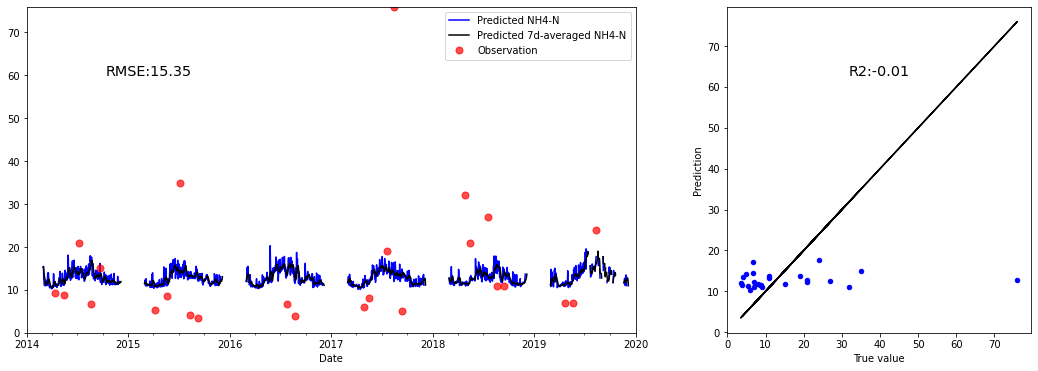

In [66]:
## Predict nutrient 5
nutrient = input('Nutrient: ')
print(features)
delet = input('Delete features? (Y/N)')
while delet=='Y':
    print(features)
    idx = int(input('Location of the feature:'))
    features.pop(idx)
    delet = input('Delete features? (Y/N)')
add = input('Add features? (Y/N)')
while add =='Y':
    f = input('New feature:')
    features.append(f)
    print(features)
    add = input('Add features? (Y/N)')    
    
loss_func='huber'
model = training_cv(all_df,features,nutrient,training_yr,loss_func)
ylim = (0,all_df[nutrient].max())
Lake_Nut,f2 = predict(testing_daily_df,all_df,features,nutrient,test_time,ylim)
f2.savefig(lakename+'_GBR_'+nutrient+'.png',dpi = 500)

Nutrient: Si
['thermD', 'MLD', 'W', 'U', 'CC', 'AirT', 'AirP', 'Prec', 'RelHum', 'swr', 'Inflow', 'delT', 'Ice_d', 'day_from_iceoff', 'NOX', 'O2', 'PO4-P', 'Tot-P', 'NH4-N']
Delete features? (Y/N)N
Add features? (Y/N)N
Training dataset evaluation:
RMSE 0.94 (+/- 0.16)
R2 0.50 (+/- 0.12)


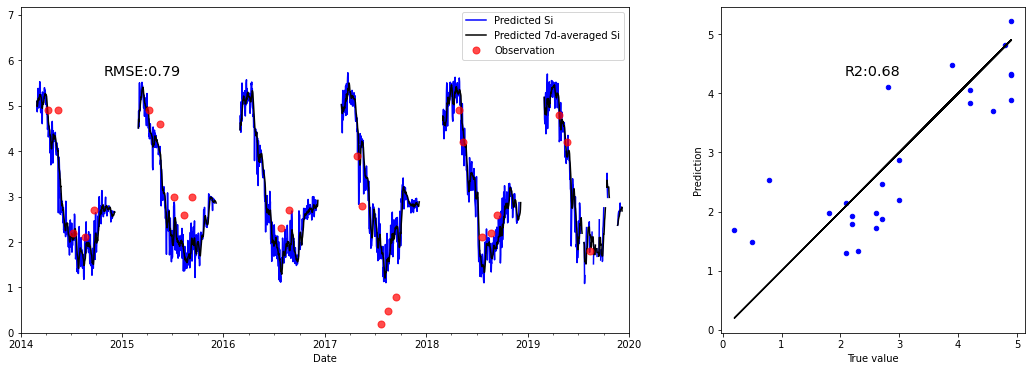

In [69]:
## Predict nutrient 6
nutrient = input('Nutrient: ')
print(features)
delet = input('Delete features? (Y/N)')
while delet=='Y':
    print(features)
    idx = int(input('Location of the feature:'))
    features.pop(idx)
    delet = input('Delete features? (Y/N)')
add = input('Add features? (Y/N)')
while add =='Y':
    f = input('New feature:')
    features.append(f)
    print(features)
    add = input('Add features? (Y/N)')    
    
loss_func='absolute_error'
model = training_cv(all_df,features,nutrient,training_yr,loss_func)
ylim = (0,all_df[nutrient].max())
Lake_Nut,f2 = predict(testing_daily_df,all_df,features,nutrient,test_time,ylim)
f2.savefig(lakename+'_GBR_'+nutrient+'.png',dpi = 500)

Nutrient: TOC
['RelHum', 'SWR', 'CC', 'Prec', 'U', 'delT', 'inflow(m3/s)', 'outflow(m3/s)', 'Ice_d', 'days from iceoff', 'W', 'MLD', 'thermD', 'O2', 'NO3N', 'NH4N', 'PO4P', 'TOTP']
Delete features? (Y/N)N
Add features? (Y/N)Y
New feature:TOTN
['RelHum', 'SWR', 'CC', 'Prec', 'U', 'delT', 'inflow(m3/s)', 'outflow(m3/s)', 'Ice_d', 'days from iceoff', 'W', 'MLD', 'thermD', 'O2', 'NO3N', 'NH4N', 'PO4P', 'TOTP', 'TOTN']
Add features? (Y/N)N
Training dataset evaluation:
RMSE 0.67 (+/- 0.42)
R2 -0.54 (+/- 0.38)


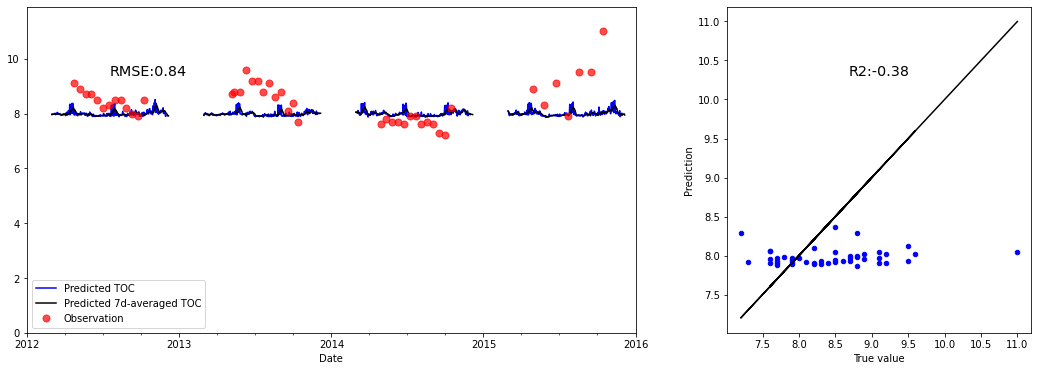

In [23]:
## Predict nutrient 7
nutrient = input('Nutrient: ')
print(features)
delet = input('Delete features? (Y/N)')
while delet=='Y':
    print(features)
    idx = int(input('Location of the feature:'))
    features.pop(idx)
    delet = input('Delete features? (Y/N)')
    
add = input('Add features? (Y/N)')
while add =='Y':
    f = input('New feature:')
    features.append(f)
    print(features)
    add = input('Add features? (Y/N)')  
    
loss_func='huber'
model = training_cv(all_df,features,nutrient,training_yr,loss_func)
ylim = (0,all_df[nutrient].max())
Lake_Nut,f2 = predict(testing_daily_df,all_df,features,nutrient,test_time,ylim)
f2.savefig(lakename+'_GBR_'+nutrient+'.png',dpi = 500)

Nutrient: SiO2
['RelHum', 'SWR', 'CC', 'Prec', 'U', 'delT', 'inflow(m3/s)', 'outflow(m3/s)', 'Ice_d', 'days from iceoff', 'W', 'MLD', 'thermD', 'O2', 'NO3N', 'NH4N', 'PO4P', 'TOTP', 'TOTN']
Delete features? (Y/N)N
Add features? (Y/N)Y
New feature:TOC
['RelHum', 'SWR', 'CC', 'Prec', 'U', 'delT', 'inflow(m3/s)', 'outflow(m3/s)', 'Ice_d', 'days from iceoff', 'W', 'MLD', 'thermD', 'O2', 'NO3N', 'NH4N', 'PO4P', 'TOTP', 'TOTN', 'TOC']
Add features? (Y/N)N
Training dataset evaluation:
RMSE 0.77 (+/- 0.23)
R2 0.58 (+/- 0.13)


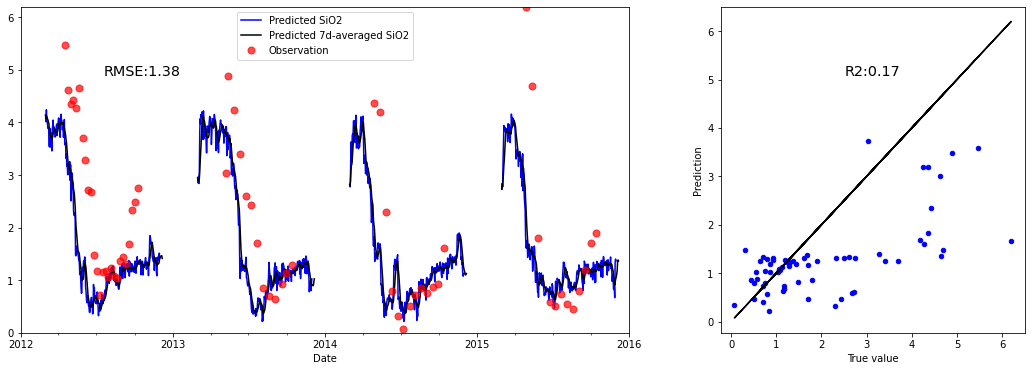

In [24]:
## Predict nutrient 8
nutrient = input('Nutrient: ')
print(features)
delet = input('Delete features? (Y/N)')
while delet=='Y':
    print(features)
    idx = int(input('Location of the feature:'))
    features.pop(idx)
    delet = input('Delete features? (Y/N)')
    
add = input('Add features? (Y/N)')
while add =='Y':
    f = input('New feature:')
    features.append(f)
    print(features)
    add = input('Add features? (Y/N)')    
    
loss_func='huber'
model = training_cv(all_df,features,nutrient,training_yr,loss_func)
ylim = (0,all_df[nutrient].max())
Lake_Nut,f2 = predict(testing_daily_df,all_df,features,nutrient,test_time,ylim)
f2.savefig(lakename+'_GBR_'+nutrient+'.png',dpi = 500)

Nutrient: Chl
['thermD', 'MLD', 'W', 'U', 'CC', 'AirT', 'AirP', 'Prec', 'RelHum', 'swr', 'Inflow', 'delT', 'Ice_d', 'day_from_iceoff', 'NOX', 'O2', 'PO4-P', 'Tot-P', 'NH4-N']
Delete features? (Y/N)N
Add features? (Y/N)Y
New feature:Si
['thermD', 'MLD', 'W', 'U', 'CC', 'AirT', 'AirP', 'Prec', 'RelHum', 'swr', 'Inflow', 'delT', 'Ice_d', 'day_from_iceoff', 'NOX', 'O2', 'PO4-P', 'Tot-P', 'NH4-N', 'Si']
Add features? (Y/N)N
Training dataset evaluation:
RMSE 8.51 (+/- 1.95)
R2 0.31 (+/- 0.11)


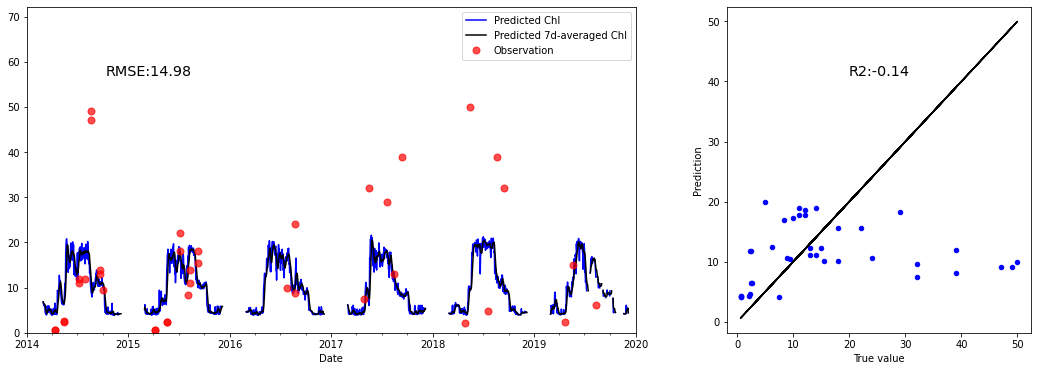

In [72]:
## Predict Chl
nutrient = input('Nutrient: ')
print(features)
delet = input('Delete features? (Y/N)')
while delet=='Y':
    print(features)
    idx = int(input('Location of the feature:'))
    features.pop(idx)
    delet = input('Delete features? (Y/N)')
add = input('Add features? (Y/N)')
while add =='Y':
    f = input('New feature:')
    features.append(f)
    print(features)
    add = input('Add features? (Y/N)') 
    
loss_func='huber'
model = training_cv(all_df,features,nutrient,training_yr,loss_func)
ylim = (0,all_df[nutrient].max())
Lake_Nut,f2 = predict(testing_daily_df,all_df,features,nutrient,test_time,ylim)
f2.savefig(lakename+'_GBR_'+nutrient+'.png',dpi = 500)

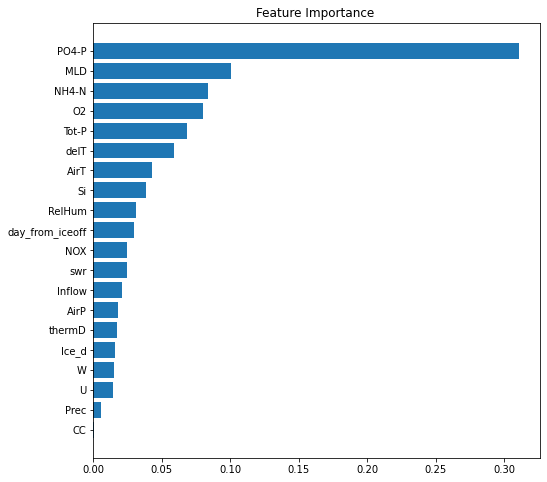

In [73]:
GBR = pickle.load(open('GBR.'+nutrient+'.dat','rb'))
feature_importance = GBR.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(8, 8))
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(features)[sorted_idx])
plt.title("Feature Importance ")

#shap_values = shap.TreeExplainer(GBR).shap_values(Lake_Nut[features])
#shap.summary_plot(shap_values,Lake_Nut[features],plot_type = 'bar',show=False)
plt.savefig(lakename+'_Feature ranking.png')

In [45]:
Lake_Nut.to_csv(lakename+'_GBR predicted nutrient and Chl.csv',index = False)